# Packages

In [2]:
import sys
# Appending python modules so we can run simulations
sys.path.append("../python")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pilot4
import os
from utility import load_scene
from pymunk.vec2d import Vec2d
import numpy as np
import json

pygame 2.1.2 (SDL 2.0.18, Python 3.9.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Plotting parameters

In [3]:
sns.set_palette("tab10")
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set(rc={'figure.figsize':(12,10)})

# Helper functions

In [4]:
def save_plot(df1, df2, df3, filename, responses, save=False):
    scene_type = filename.split('/')[-1]
    # Set figure object
    fig, axs = plt.subplots(1,4,figsize=(24,6),gridspec_kw={'width_ratios': [1,1.5,1.5,1.5]})
    # Title subplots
    axs[0].title.set_text("Runtime per cumulative distance traveled from origin to Goal")
    axs[1].title.set_text("Predicted RT for pure simulation")
    axs[2].title.set_text("Predicted RT for abstraction")
    axs[3].title.set_text("Empirical RT per Goal Position")
    # Set subplots
    g=sns.scatterplot(x="x", 
                      y="y", 
                      hue="runtime",
                      s=200,
                      data=df1,
                      palette="coolwarm",
                      edgecolor="none",
                      ax=axs[0])
    g.set(ylim=(0, 1000),xlim=(0,800))
    g.invert_yaxis()
    
    g=sns.scatterplot(x="distance_cumulative",
                      y="runtime",
                      hue="runtime",
                      s=200,
                      data=df2,
                      edgecolor="none",
                      palette="coolwarm",
                      ax=axs[1])
    g.set(ylim=(0, 400),xlim=(0,1200))
    
    g=sns.scatterplot(x="distance_cumulative",
                      y="runtime",
                      hue="runtime",
                      s=200,
                      data=df3,
                      edgecolor="none",
                      palette="tab10",
                      ax=axs[2])
    g.set(ylim=(0, 400),xlim=(0,1200))
    
    g = sns.lineplot(x='distance',
                      y='part_zrt',
                      data=responses.loc[(responses.scene_type == scene_type) & (responses.scene_col == "yes") & (responses.correct == True)],
                      hue='model_abs_rt',
                     marker='o', ci=95,
                      palette="tab10",
                      ax=axs[3])
    g.set(xlim=(0,1200))
    
    g = sns.lineplot(x='distance',
                      y='model_abs_rt',
                      data=responses.loc[(responses.scene_type == scene_type) & (responses.scene_col == "yes") & (responses.correct == True)],
                      hue='model_abs_rt',
                     marker='o', ci=95,
                      palette="tab10",
                      ax=axs[3])
    g.set(xlim=(0,1200))
    
    if save:
        plt.savefig(filename)
    else:
        plt.show()

# Importing and cleaning data

## Importing data

In [5]:
# Experiment 4
data_path_exp4 = "../experiments/experiment4/data/data.csv"
# Experiment 5
data_path_exp5 = "../experiments/experiment5/data/data.csv"

In [6]:
# Read in data
data_exp4 = pd.read_csv(data_path_exp4)
data_exp5 = pd.read_csv(data_path_exp5)

In [7]:
data_exp4['experiment_version'] = 4
data_exp5['experiment_version'] = 5

In [8]:
data = pd.concat([data_exp4,data_exp5],ignore_index=True)

## Cleaning data

Here, we're removing unused columns that contain metadata from jsPsych. These are unnecessary for our analyses. 

In [9]:
# Removing unused columns from jsPsych
data = data.drop(columns=['success', 
                          'failed_images',
                          'failed_audio',
                          'failed_video',
                         'time_elapsed',
                         'scene_sp',
                         'internal_node_id',
                         'session_id',
                         'study_id',
                         'value',
                         'stimulus',
                         'timeout',
                         'trial_type'])

**Removing participants who failed comprehension:** Here, we're removing participants who could not get the comprehension questions right in three tries or less.

In [10]:
# List of subjects who failed comprehension check
failed_comprehension = []
# Iterate through all subjects
for subject in pd.unique(data.subject_id):
    # Find the number of attempts they made
    attempts = data.loc[(data.subject_id == subject) & (data.task == 'comprehension')].attempts.to_list()
    if max(attempts) > 3:
        failed_comprehension.append(subject)
print(f"{len(failed_comprehension)} of {len(pd.unique(data.subject_id))} ({15/42*100:.4}%) participants failed the comprehension check")

41 of 141 (35.71%) participants failed the comprehension check


In [11]:
# Remove people who failed comprehension check
data = data.loc[~(data.subject_id.isin(failed_comprehension))]

In [12]:
# Check that none of the remaining subjects also failed the comprehension check
l = pd.unique(data.subject_id)
all([x in failed_comprehension for x in l])

False

**Cleaning responses:** In line with good practice with dataframes, we are making a copy of our original dataframe `data` for analysis and calling it `responses`

In [13]:
# Copy dataframe
responses = data

In [14]:
# Remove attempts column since we no longer are using it
responses = responses.drop(columns=['attempts'])

**Cleaning scene types:** Our variable `scene_type` codes which scene type the participant is viewing (e.g. stim_2, stim_4, or stim_6). jsPsych records these data verbosely (e.g. "stim_2_goalpos_1_negative.mp4"). Here, we're cleaning up the `scene_type` entries so they just say what scene type the user viewed. For example, the entry "stim_2_goalpos_1_negative.mp4" will be changed to "stim_2".

In [15]:
# Convert all scene type entries to strings
responses.scene_type = responses.scene_type.astype(str)
# Retain only the scene type (remove "_goalpos_" substring)
responses.scene_type = responses.scene_type.apply(lambda x: "_".join(x.split('_')[:2]))

**Cleaning scenes:** The `scene` variable codes the actual scene the participant viewed (e.g. "stim_2_goalpos_1_negative.mp4"). We want to remove the ".mp4" substring from the entries in this variable.

In [16]:
# Convert all scene entries to strings
responses.scene = responses.scene.astype(str)
# Retain only the scene name (remove ".mp4" substring)
responses.scene = responses.scene.apply(lambda x: x.split('.')[0])

**Only viewing responses:** Since we removed the participants who failed the comprehension check, we are now only interested in the remaining participants' responses. So, we're removing the data that isn't coded as "response" in the `task` variable.

In [17]:
# Remove all tasks that aren't coded as response
responses = responses.loc[(responses.task == 'response')]

In [18]:
# Remove the task column since we no longer are using it
responses = responses.drop(columns=['task'])



**Compute z-scores:** We need to compute the z-scores of response times `rt`. We will do so participant-wise (per participant) and variable-wise (across the variable `rt`), and add them as new variables `part_zrt` and `var_zrt` respsectively.

In [19]:
# Calculate variable-wise z-scores for response time
responses['var_zrt'] = responses.groupby('experiment_version').rt.apply(lambda x: (x-x.mean()) / x.std())

In [20]:
# Calculate participant-wise z-score for response time
responses['part_zrt'] = responses.groupby(['experiment_version','subject_id']).rt.apply(lambda x: (x-x.mean()) / x.std())

In [21]:
# Check these z-scores are not equivalent
all(responses['var_zrt'] == responses['part_zrt'])
# sns.scatterplot(x="var_zrt",y="part_zrt", data=responses) # Should be a straight line if they're the same

False

**Removing outlier response times**: We can now remove outlier response times. We use the 2-SD methd as per Alexander Berger and Markus Kiefer, 2021. 2-SD outlier exclusion demonstrated best results for omitting Type-1 errors (false positives) and retaining original data.

In [22]:
# Determine number of datapoints lost by outlier exclusion
excluded = len(responses) - len(responses[abs(responses.part_zrt) <= 2])
print(f"{excluded} of {len(responses)} ({excluded/len(responses)*100:.4}%) are excluded via 2-SD exclusion")

409 of 9000 (4.544%) are excluded via 2-SD exclusion


In [23]:
# Excluding outliers
responses = responses[abs(responses.part_zrt) <= 2]

# Analysis

## Normalized RT per `scene_type`

**Plotting average RT per scene type:** Here we're plotting the normalized RT `part_zrt` per scene type, partitioned by whether the scene contained a collision or not. Collision is coded by the binary `scene_col` variable.

<AxesSubplot:title={'center':'Experiment 5'}, xlabel='scene_type', ylabel='part_zrt'>

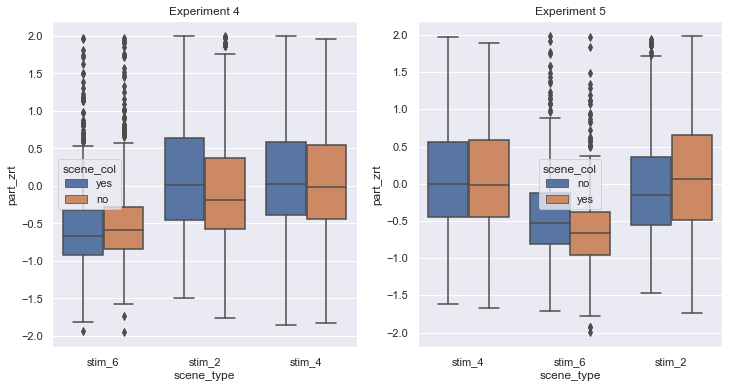

In [24]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
axs[0].title.set_text("Experiment 4")
axs[1].title.set_text("Experiment 5")
sns.boxplot(x="scene_type",y="part_zrt",hue="scene_col",data=responses.loc[responses.experiment_version==4],ax=axs[0])
sns.boxplot(x="scene_type",y="part_zrt",hue="scene_col",data=responses.loc[responses.experiment_version==5],ax=axs[1])

## Normalized RT per `scene`

**Plotting participant z-RT per scene:** Here we're plotting the normalized RT `part_zrt` per `scene_index`, partitioned by `scene_type`. 

<AxesSubplot:title={'center':'RT Across Experiments 4 and 5'}, xlabel='scene_index', ylabel='part_zrt'>

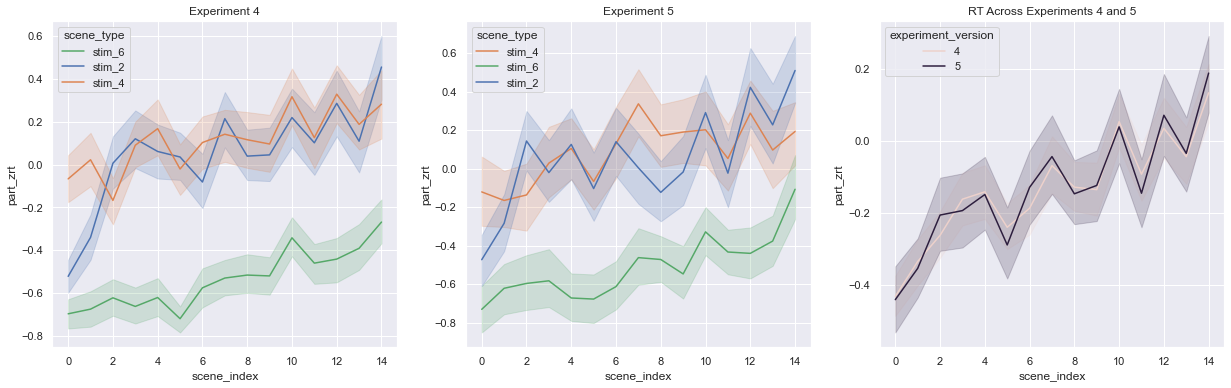

In [177]:
# Color palette to maintain consistency across plots
palette ={"stim_2": "C0", "stim_4": "C1", "stim_6": "C2"}

fig, axs = plt.subplots(1,3,figsize=(21,6))
axs[0].title.set_text("Experiment 4")
axs[1].title.set_text("Experiment 5")
axs[2].title.set_text("RT Across Experiments 4 and 5")
sns.lineplot(x="scene_index",y="part_zrt",hue="scene_type",data=responses.loc[responses.experiment_version==4],ax=axs[0],palette=palette)
sns.lineplot(x="scene_index",y="part_zrt",hue="scene_type",data=responses.loc[responses.experiment_version==5],ax=axs[1],palette=palette)
sns.lineplot(x="scene_index",y="part_zrt",hue="experiment_version",data=responses,ax=axs[2])

**Empirical RT distributions:** Here, we're investigating the spread and tendencies of RT distributions. 

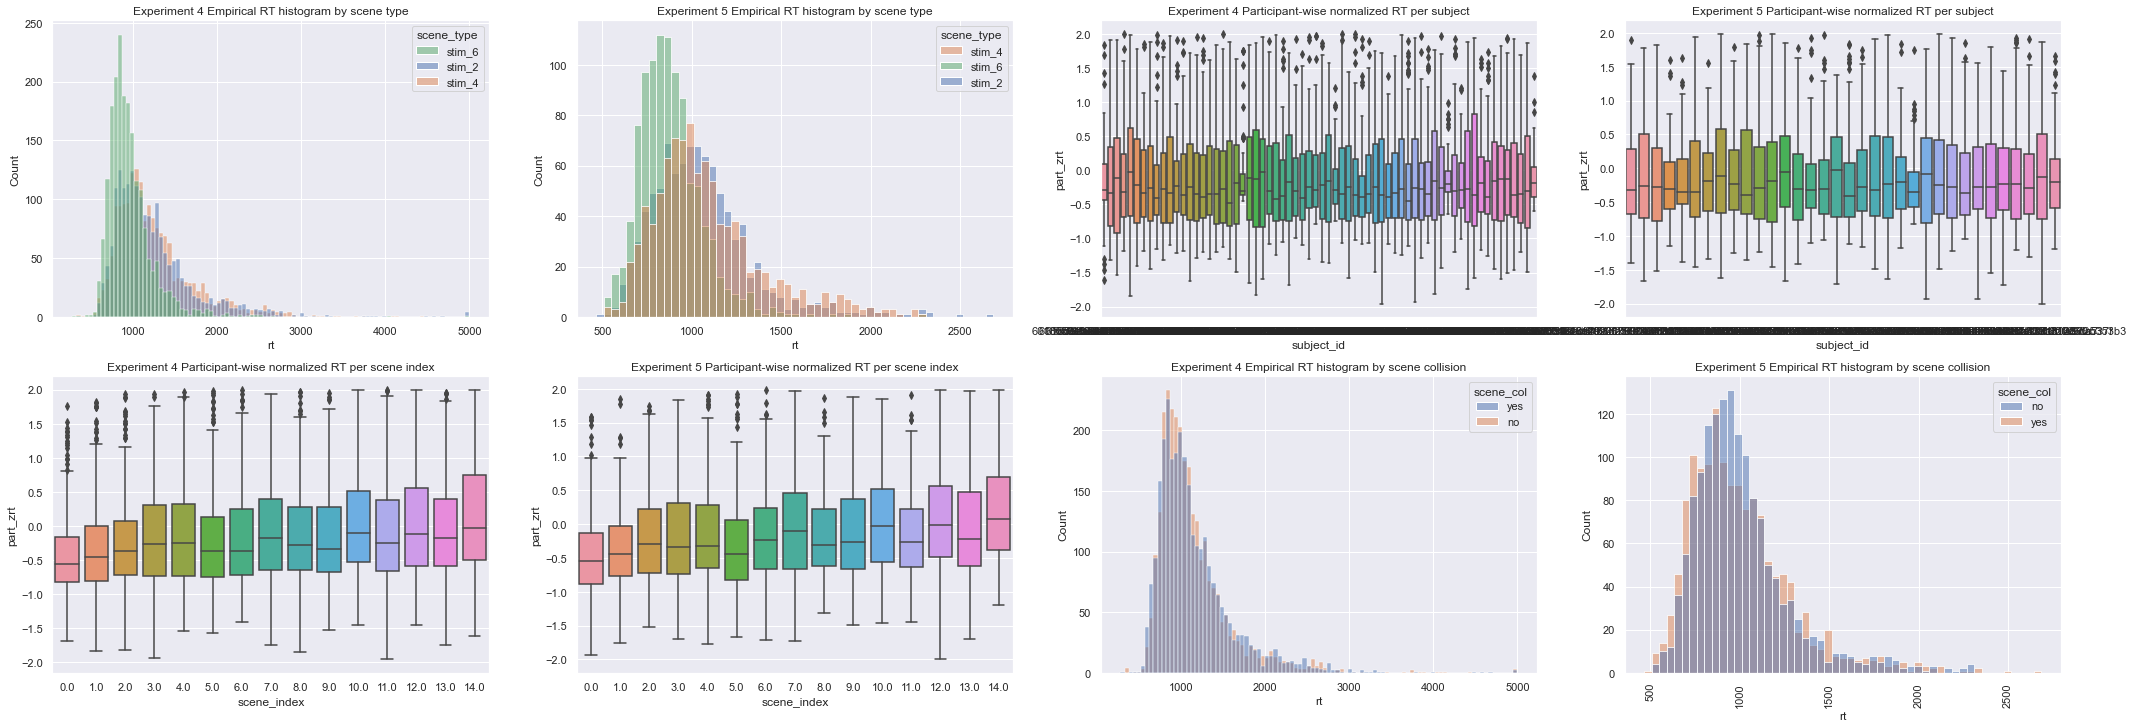

In [66]:
fig, axs = plt.subplots(2,4,figsize=(36,12))
# Title subplots
axs[0,0].title.set_text("Experiment 4 Empirical RT histogram by scene type")
axs[0,1].title.set_text("Experiment 5 Empirical RT histogram by scene type")
axs[0,2].title.set_text("Experiment 4 Participant-wise normalized RT per subject")
axs[0,3].title.set_text("Experiment 5 Participant-wise normalized RT per subject")

axs[1,0].title.set_text("Experiment 4 Participant-wise normalized RT per scene index")
axs[1,1].title.set_text("Experiment 5 Participant-wise normalized RT per scene index")
axs[1,2].title.set_text("Experiment 4 Empirical RT histogram by scene collision")
axs[1,3].title.set_text("Experiment 5 Empirical RT histogram by scene collision")

sns.histplot(x="rt",data=responses.loc[responses.experiment_version==4],hue='scene_type',ax=axs[0,0],palette=palette)
sns.histplot(x="rt",data=responses.loc[responses.experiment_version==5],hue='scene_type',ax=axs[0,1],palette=palette)
sns.boxplot(x='subject_id',y='part_zrt',data=responses.loc[responses.experiment_version==4],ax=axs[0,2])
sns.boxplot(x='subject_id',y='part_zrt',data=responses.loc[responses.experiment_version==5],ax=axs[0,3])
sns.boxplot(x='scene_index',y='part_zrt',data=responses.loc[responses.experiment_version==4],ax=axs[1,0])
sns.boxplot(x='scene_index',y='part_zrt',data=responses.loc[responses.experiment_version==5],ax=axs[1,1])
sns.histplot(x="rt",data=responses.loc[responses.experiment_version==4],hue='scene_col',ax=axs[1,2])
sns.histplot(x="rt",data=responses.loc[responses.experiment_version==5],hue='scene_col',ax=axs[1,3])
plt.xticks(rotation=90);

**Calculating scene accuracies:** Here we calculate the accuracy per scene.

In [27]:
responses['scene_accuracy'] = responses.groupby(['experiment_version','scene','scene_col']).correct.transform(lambda x: sum(x) / len(x))

In [28]:
responses['part_accuracy'] = responses.groupby(['experiment_version','subject_id']).correct.transform(lambda x: sum(x) / len(x))

In [29]:
responses['scene_index_accuracy'] = responses.groupby(['experiment_version','scene_index','scene_type']).correct.transform(lambda x: sum(x) / len(x))

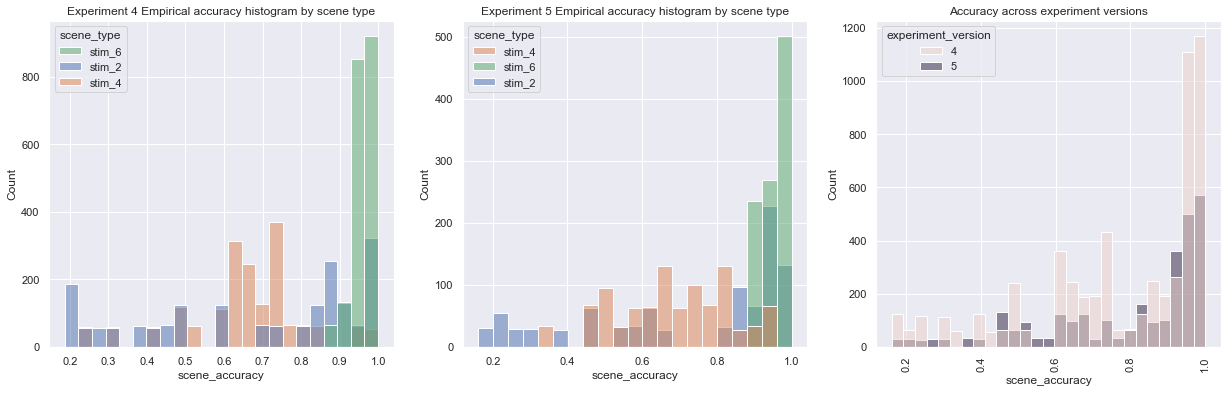

In [178]:
fig, axs = plt.subplots(1,3,figsize=(21,6))
# Title subplots
axs[0].title.set_text("Experiment 4 Empirical accuracy histogram by scene type")
axs[1].title.set_text("Experiment 5 Empirical accuracy histogram by scene type")
axs[2].title.set_text("Accuracy across experiment versions")
sns.histplot(x="scene_accuracy",data=responses.loc[responses.experiment_version==4],ax=axs[0],hue="scene_type",palette=palette)
sns.histplot(x="scene_accuracy",data=responses.loc[responses.experiment_version==5],ax=axs[1],hue="scene_type",palette=palette)
sns.histplot(x="scene_accuracy",data=responses,ax=axs[2],hue="experiment_version")
plt.xticks(rotation=90);

In [36]:
from scipy.stats import ttest_ind,mannwhitneyu,shapiro

exp_4_scene_acc = list(responses.loc[responses.experiment_version==4].scene_accuracy)
exp_5_scene_acc = list(responses.loc[responses.experiment_version==5].scene_accuracy)

shap_exp4 = shapiro(exp_4_scene_acc)
shap_exp5 = shapiro(exp_5_scene_acc)

print(f"Shapiro Test Results:")
print(f"\tExperiment 4 data is: {'not' if shap_exp4.pvalue < 0.05 else ''} normal with p-val = {shap_exp4.pvalue}.")
print(f"\tExperiment 5 data is: {'not' if shap_exp5.pvalue < 0.05 else ''} normal with p-val = {shap_exp5.pvalue}.")
print("")

u_res = mannwhitneyu(exp_4_scene_acc, exp_5_scene_acc, alternative="less")
print(f"MWU Results:")
print(f"\tExperiment 4 scene accuracy is {'' if u_res.pvalue < 0.05 else 'not'} significantly less than Experiment 5 scene accuracy with p-val = {u_res.pvalue}")

Shapiro Test Results:
	Experiment 4 data is: not normal with p-val = 0.0.
	Experiment 5 data is: not normal with p-val = 0.0.

MWU Results:
	Experiment 4 scene accuracy is not significantly less than Experiment 5 scene accuracy with p-val = 0.24827692730301498


/Users/lollipop/miniconda3/envs/physabs/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


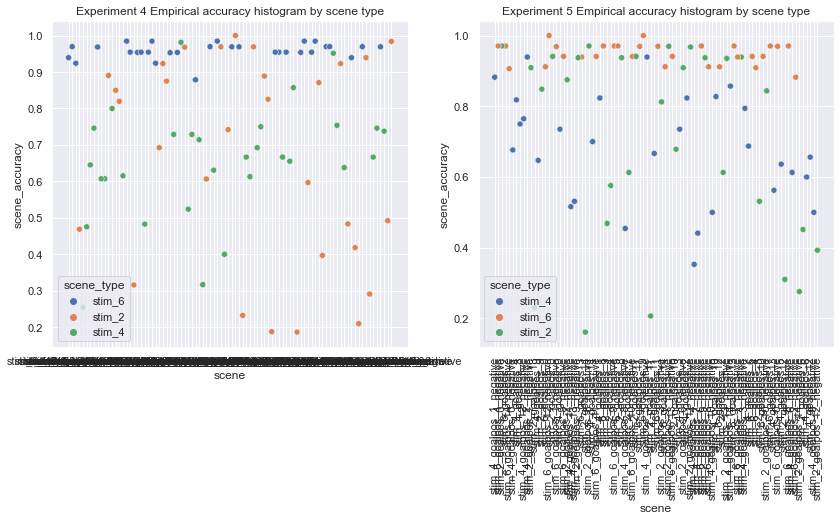

In [55]:
fig, axs = plt.subplots(1,2,figsize=(14,6))
# Title subplots
axs[0].title.set_text("Experiment 4 Empirical accuracy histogram by scene type")
axs[1].title.set_text("Experiment 5 Empirical accuracy histogram by scene type")
sns.scatterplot(x="scene",y='scene_accuracy',hue='scene_type',data=responses.loc[responses.experiment_version==4],ax=axs[0])
plt.xticks(rotation=90);
sns.scatterplot(x="scene",y='scene_accuracy',hue='scene_type',data=responses.loc[responses.experiment_version==5],ax=axs[1])
plt.xticks(rotation=90);

# Modeling

In line with good dataframe practice, we create a copy of our `responses` dataframe for our modeling efforts and name it `model`.

In [123]:
# Make a copy of our resposnes dataframe
model = responses

**Model parameters:** While we haven't fit our model to the data yet, we can use our best-fitting parameter settings from our last experiment. These are:

**N: 35
D: 200
E: 0.9**

In [124]:
# Working parameters (for now)
model_parameters = (35, 200, 0.99)

## Computing model predictions

### Simulation time predictions

#### Computing simulation times per scene

**Computing simulation times:** Here we're going through each of the scenarios given to participants and computing the expected simulation time for each scenario according to a full simulation model `model_sim` and an abstraction model `model_abs`. We store these results in our dataframe `model`.

In [125]:
# Director with relevant JSONs
loaddir = "../data/json/pilot4/trial/"
# Gather all of the json files in the directory of trial stimuli
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

In [126]:
# Dictionary that will contain our model results
simtime = {}

# Iterate through stimuli files
for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Load the stimuli
    scene = load_scene(loaddir+file)
    # Instatiate the scene
    scene.instantiate_scene()
    # Run our model on the scene, with the given parameter setting
    scene.run_path(False,*model_parameters)
    # Get model-predicted simulation time
    st = scene.physics.tick
    # Add this scene, simulation time prediction to our dictionary
    simtime[scene_name] = st

Now we merge our `model` dataframe with these predictions

In [127]:
# Dataframe with simulation times
sim_predictions = pd.DataFrame.from_dict(simtime, orient='index')
# Reset the index so we can merge these results on the scene variable
sim_predictions = sim_predictions.reset_index()
# Rename the variables appropriately, so they match the variables in model dataframe
sim_predictions = sim_predictions.rename(columns = {'index':'scene',0:'model_abs_rt'})

In [128]:
# Merge the model predictions into our model dataframe
model = model.merge(sim_predictions, on="scene")

Here we repeat the process for the pure simulation model predictions (yes, this should be cleaner / abstracted)

In [129]:
# Dictionary that will contain our model results
simtime = {}

# Iterate through stimuli files
for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Load the stimuli
    scene = load_scene(loaddir+file)
    # Instatiate the scene
    scene.instantiate_scene()
    # Run our model on the scene, with the given parameter setting
    scene.run(False)
    # Get model-predicted simulation time
    st = scene.physics.tick
    # Add this scene, simulation time prediction to our dictionary
    simtime[scene_name] = st

Now we merge our `model` dataframe with these predictions

In [130]:
# Dataframe with simulation times
sim_predictions = pd.DataFrame.from_dict(simtime, orient='index')
# Reset the index so we can merge these results on the scene variable
sim_predictions = sim_predictions.reset_index()
# Rename the variables appropriately, so they match the variables in model dataframe
sim_predictions = sim_predictions.rename(columns = {'index':'scene',0:'model_sim_rt'})

In [131]:
# Merge the model predictions into our model dataframe
model = model.merge(sim_predictions, on="scene")

#### Computing distances travelled by the Ball

This isn't important for our work, but a necessary step for us to plot our modeling results.

Here, we're computing the distances travelled by the ball for each scenario according to pure simulation, and appending those distances to our `model` dataframe.

In [132]:
# Dictionary that will contain distance travelled per scenario 
distances = {}

# Iterate through stimuli files
for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Open the JSON file
    with open(loaddir+file, 'r') as f:
        # Grab the scene arguments
        scene_args = json.loads(f.read())
    # Extract the origin (the ball's starting position)
    origin = scene_args['ball_args'][0]
    # Extract the goal position
    goal = scene_args['goal_args'][0]
    # Convert these points into Vec2d for compatibility with pymunk
    origin = Vec2d(*origin)
    goal = Vec2d(*goal)
    # Compute the distance
    distance = origin.get_distance(goal)
    # Add the scene, distance pair into the dataframe
    distances[scene_name] = distance

Now we merge our `model` dataframe with these predictions

In [133]:
# Dataframe with simulation times
distance_df = pd.DataFrame.from_dict(distances, orient='index')
# Reset the index so we can merge these results on the scene variable
distance_df = distance_df.reset_index()
# Rename the variables appropriately, so they match the variables in model dataframe
distance_df = distance_df.rename(columns = {'index':'scene',0:'distance'})

In [134]:
# Merge the distance values with our model dataframe
model = model.merge(distance_df, on="scene")

## Plotting model predictions

**Plotting predictions:** Here, we're plotting the model predictions of simulation time along with the empirical data.

stim_4.json


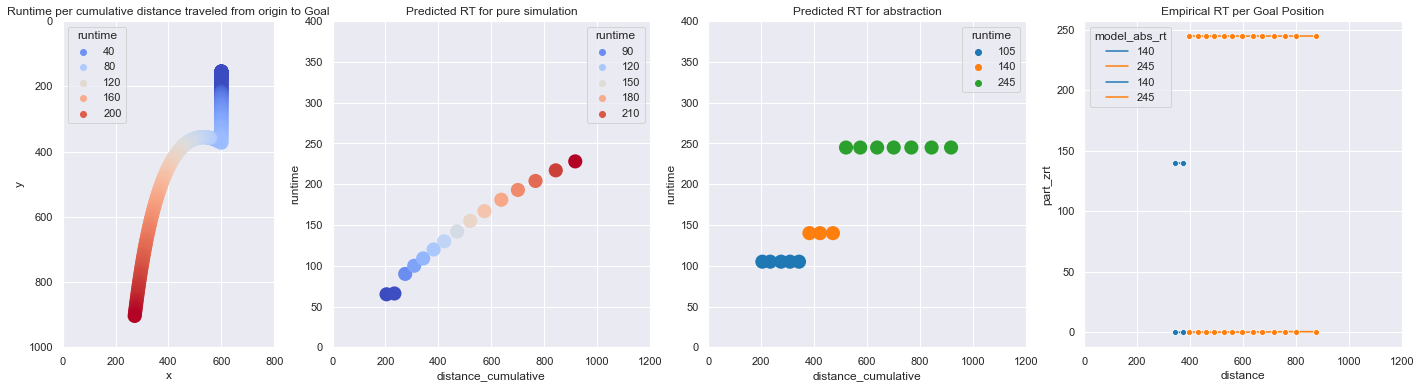

stim_2.json


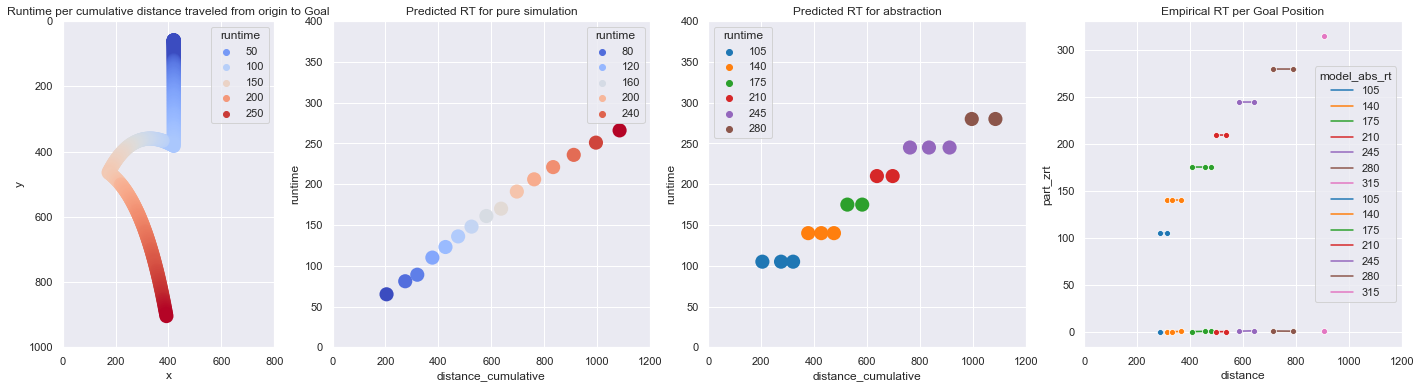

stim_6.json


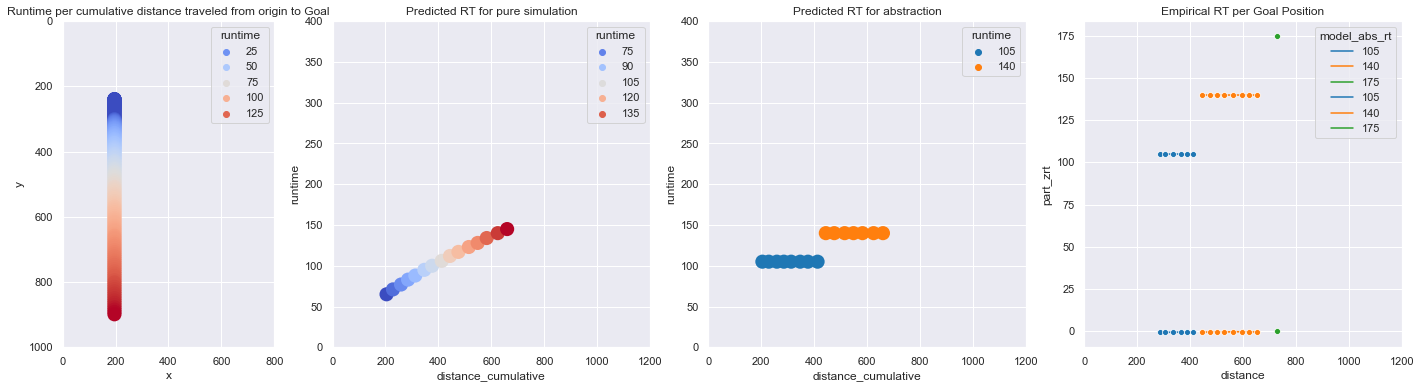

In [157]:
# Directory with relevant JSONs
loaddir = "../data/json/pilot4/types/"
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

for file in json_files:
    print(file)
    # Grab the full trace of ball's trajectory
    full_trace = pilot4.scene_trace(loaddir+file)
    # Grab the sparse trace of ball's trajectory
    sparse_trace = pilot4.get_points(full_trace)
    # Grab RT prediction from simulation model
    sim_full = pilot4.scene_rt(full_trace, loaddir+file)
    
    # Grab RT prediction from abstraction model
    abs_sparse = pilot4.scene_rt(sparse_trace, loaddir+file, abstraction=True,params=model_parameters)
    # Grab RT prediction from simulation model
    sim_sparse = pilot4.scene_rt(sparse_trace, loaddir+file)
    
    # Plot results
    save_plot(df1=sim_full,
              df2=sim_sparse,
              df3=abs_sparse,
              filename=loaddir+file.split('.')[0],
              responses=model)

**Comparing normalized predictions with RT:** Here, we're normalizing the RT predictions of the model and plotting them against the normalized RT data from participants.

In [136]:
model['model_abs_zrt'] = model.groupby('subject_id').model_abs_rt.transform(lambda x: (x - x.mean()) / x.std())
model['model_sim_zrt'] = model.groupby('subject_id').model_sim_rt.transform(lambda x: (x - x.mean()) / x.std())

<AxesSubplot:title={'center':'Experiment 5 rt against Experiment 5 rt'}, xlabel='part_zrt', ylabel='part_zrt'>

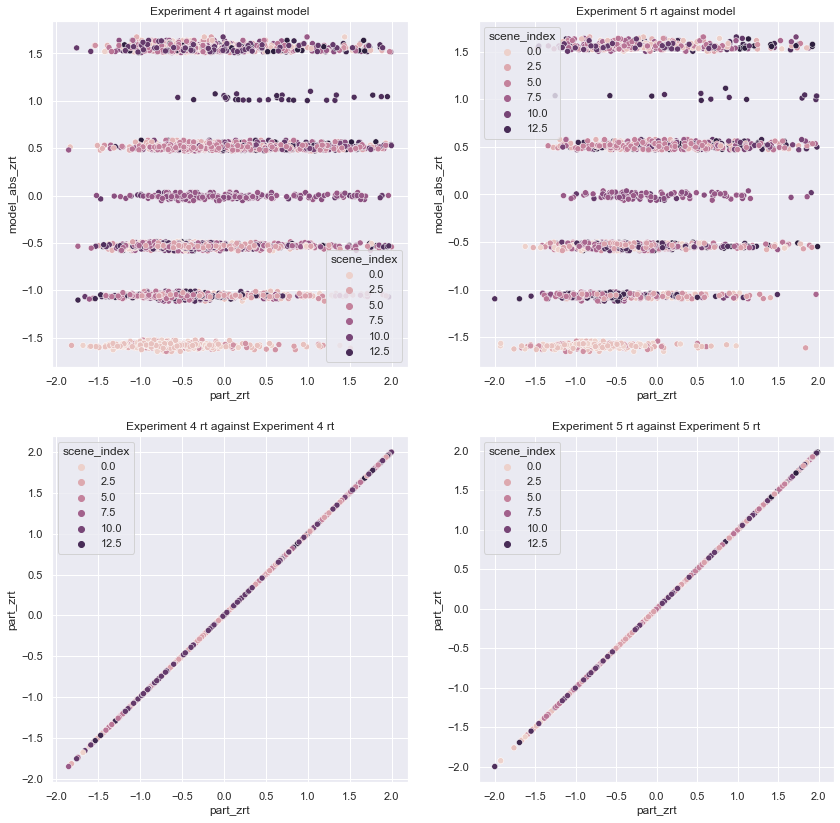

In [137]:
fig, axs = plt.subplots(2,2,figsize=(14,14))
# Title subplots
axs[0,0].title.set_text("Experiment 4 rt against model")
axs[0,1].title.set_text("Experiment 5 rt against model")
axs[1,0].title.set_text("Experiment 4 rt against Experiment 4 rt")
axs[1,1].title.set_text("Experiment 5 rt against Experiment 5 rt")
sns.scatterplot(x="part_zrt",y='model_abs_zrt',hue='scene_index',data=model.loc[(model.experiment_version==4) & (model.correct==True)],ax=axs[0,0])
sns.scatterplot(x="part_zrt",y='model_abs_zrt',hue='scene_index',data=model.loc[(model.experiment_version==5) & (model.correct==True)],ax=axs[0,1])
sns.scatterplot(x="part_zrt",y='part_zrt',hue='scene_index',data=model.loc[(model.experiment_version==4) & (model.correct==True)],ax=axs[1,0])
sns.scatterplot(x="part_zrt",y='part_zrt',hue='scene_index',data=model.loc[(model.experiment_version==5) & (model.correct==True)],ax=axs[1,1])

## Predicting expected variance

**Computing expected variance according to our model:** Here we compute the expected variance in participant response times under our model setting, by computing the variance in the model prediction distribution for each scene.

In [138]:
# Importing our model
from models import abstraction_stochastic

First, we sample our model for simulation time distributions per scene, and store these samples in `model_distributions` dictionary

In [139]:
# Director with relevant JSONs
loaddir = "../data/json/pilot4/trial/"
# Gather all of the json files in the directory of trial stimuli
json_files = [pos_json for pos_json in os.listdir(loaddir) if pos_json.endswith('.json')]

In [140]:
# Dictionary that will contain our model results
model_distributions = {}

for file in json_files:
    # Scene name
    scene_name = file.split(".")[0]
    # Open the JSON file
    with open(loaddir+file, 'r') as f:
        # Grab the scene arguments
        scene_args = json.loads(f.read())
    model_distributions[scene_name] = abstraction_stochastic(scene_args,*model_parameters,90)

We then convert `model_predictions` into a usable dataframe `predictions` and format it for ease of use

In [141]:
# Placing model predicted distributions into datframe, using scenes as rows
predictions = pd.DataFrame.from_dict(model_distributions,orient='index')

In [142]:
# Making the scenes their own variable, so we can merge on the `scene` variable with other dataframes
predictions = predictions.reset_index()
predictions = predictions.rename(columns={'index':'scene'})

Because of the return value of our model, I am simply flattening the list of lists of simulation times into a list of simulation times.

In [143]:
# Flattening the list of simulation times (needs to be fixed in model.py)
predictions.simulation_time = predictions.simulation_time.transform(lambda x: [y[0] for y in x])

Copying our `predictions` dataframe for cleanliness

In [144]:
df = predictions

Here, we gather the variables we want to merge with our predictions from our `model` dataframe.

In [145]:
grouping_df = model[['scene','model_abs_rt','scene_type','distance','scene_col']].drop_duplicates()

Then, we merge the dataframes

In [146]:
df = df.merge(grouping_df,on='scene')

We have a list of simulation times, but we need each element occupies an individual row in our dataframe so we can work with the data easily.

In [147]:
df = df.explode('simulation_time')

Then, we compute the variable-wise (across scenes) normalized predicted simulation times for comparison with participant responses times. We store these normalized simulation times as `sim_time_z`

In [148]:
df['sim_time_z'] = df.simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [149]:
# Resetting the index
df = df.reset_index(drop=True)

**Plot model predictions against empirical RT:** Here, we're plotting the model predictions against our RT.

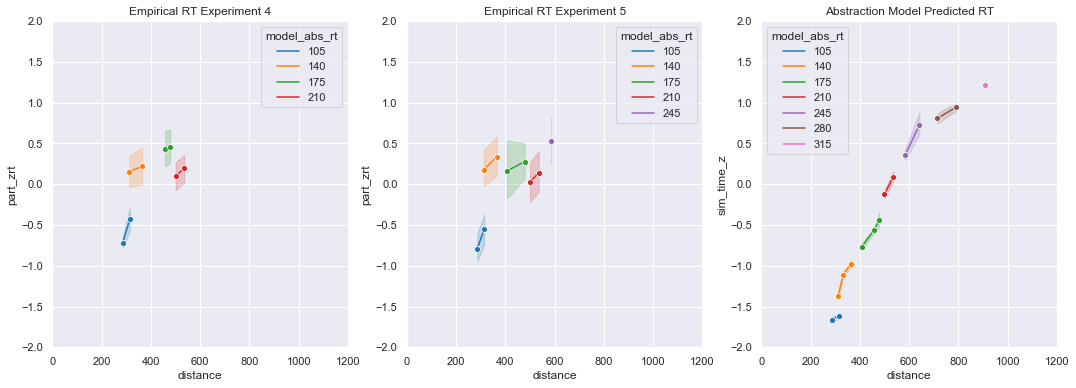

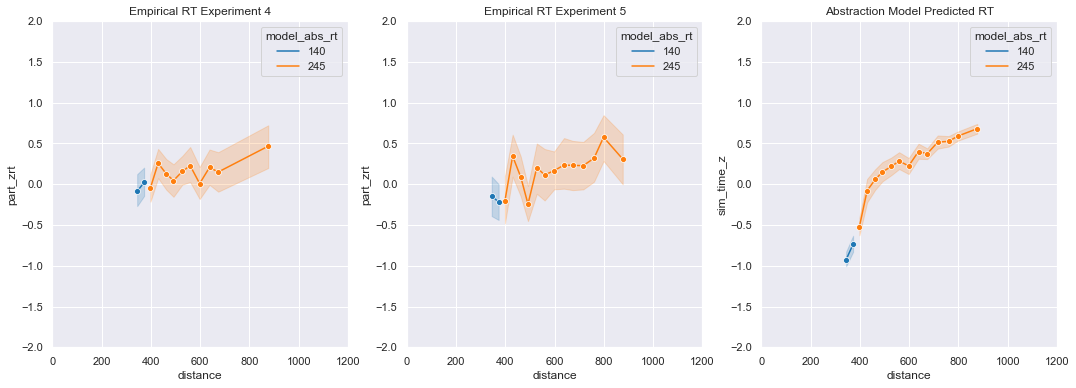

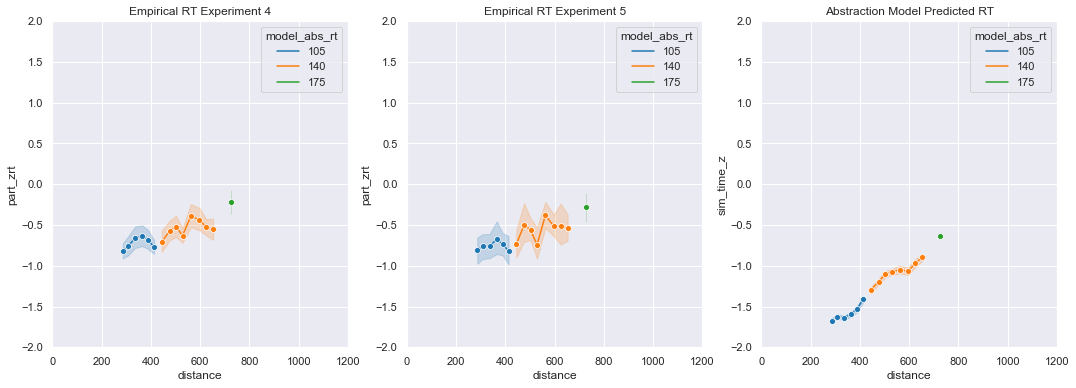

In [182]:
for scene_type in ['stim_2','stim_4','stim_6']:
    # Set figure object
    fig, axs = plt.subplots(1,3,figsize=(18,6))

    # Title subplots
    axs[0].title.set_text("Empirical RT Experiment 4")
    axs[1].title.set_text("Empirical RT Experiment 5")
    axs[2].title.set_text("Abstraction Model Predicted RT")
    
    # Plots
    g = sns.lineplot(x='distance',
                      y='part_zrt',
                      data=model.loc[(model.scene_type == scene_type) & (model.scene_col == "yes") & (model.correct == True) & (model.experiment_version == 4) & (model.scene_accuracy > 0.5)],
                      hue='model_abs_rt',
                     marker='o', ci=95,
                      palette="tab10",
                      ax=axs[0])
    g.set(xlim=(0,1200),ylim=(-2,2))

    g = sns.lineplot(x='distance',
                      y='sim_time_z',
                      data=df.loc[(df.scene_type == scene_type) & (df.scene_col == "yes")],
                      hue='model_abs_rt',
                     marker='o', ci=95,
                      palette="tab10",
                      ax=axs[2])
    g.set(xlim=(0,1200),ylim=(-2,2))
    
    g = sns.lineplot(x='distance',
                      y='part_zrt',
                      data=model.loc[(model.scene_type == scene_type) & (model.scene_col == "yes") & (model.correct == True) & (model.experiment_version == 5) & (model.scene_accuracy > 0.5)],
                      hue='model_abs_rt',
                     marker='o', ci=95,
                      palette="tab10",
                      ax=axs[1])
    g.set(xlim=(0,1200),ylim=(-2,2))

In [176]:
len(pd.unique(responses.loc[(responses.scene_type=='stim_2') & (responses.scene_accuracy > 0.7) & (responses.scene_col == 'yes')].scene))

5

### Summary statistic

In [58]:
model['model_grouping'] = model.model_abs_rt.astype(object)
df['model_grouping'] = df.model_abs_rt.astype(object)

In [59]:
scene_types = ['stim_2','stim_4','stim_6']
scene_type_groups = {s:pd.unique(model[model.scene_type == s].model_grouping) for s in scene_types}

# Compute difference between within-group var and across-group var
for s in scene_types:
    print(f"Scene {s}")
    g = scene_type_groups[s]
    g.sort()
    print(f"Groups {g}")
    for idx in range(1,len(scene_type_groups[s])):
        print(f"\tGroup {g[idx-1],g[idx]}")
        # Grab normalized RT for first group
        within_group_rt = model[(model.scene_type == s) & (model.model_grouping==g[idx-1])].part_zrt.to_list()
        # Grab normalized RT for second group
        across_group_rt = model[(model.scene_type == s) & (model.model_grouping==g[idx])].part_zrt.to_list()
        across_group_rt += within_group_rt
        print(f"\tWithin-group variance {np.var(within_group_rt)}")
        print(f"\tAcross-group variance {np.var(across_group_rt)}")
        
        # Grab normalized RT for first group
        within_group_rt = df[(df.scene_type == s) & (df.model_grouping==g[idx-1])].sim_time_z.to_list()
        # Grab normalized RT for second group
        across_group_rt = df[(df.scene_type == s) & (df.model_grouping==g[idx])].sim_time_z.to_list()
        across_group_rt += within_group_rt
        print(f"\tWithin-group variance {np.var(within_group_rt)}")
        print(f"\tAcross-group variance {np.var(across_group_rt)}")

Scene stim_2
Groups [105 140 175 210 245 280 315]
	Group (105, 140)
	Within-group variance 0.22999229095926726
	Across-group variance 0.5572362273212592
	Within-group variance 0.025221954013825744
	Across-group variance 0.10577955029542639
	Group (140, 175)
	Within-group variance 0.5351782602380581
	Across-group variance 0.5315231880451846
	Within-group variance 0.05821371222846975
	Across-group variance 0.12669203758699735
	Group (175, 210)
	Within-group variance 0.5254586935138583
	Across-group variance 0.5222106329872116
	Within-group variance 0.07476234448404924
	Across-group variance 0.16383515411460456
	Group (210, 245)
	Within-group variance 0.5195854023239403
	Across-group variance 0.566110584450395
	Within-group variance 0.11656570906815489
	Across-group variance 0.3433399975170788
	Group (245, 280)
	Within-group variance 0.6331654192920242
	Across-group variance 0.6363227366735592
	Within-group variance 0.35680757978116295
	Across-group variance 0.2676517709939025
	Group (280